In [78]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from PIL import Image

In [79]:
class data:
    u: float
    v: float
    phase: float
    amp: float
    sigma: float
    vis_data: complex
    def __init__(self, u, v, phase, amp, sigma):
        self.u = u
        self.v = v
        self.phase = phase
        self.amp = amp
        self.sigma = sigma
        self.vis_data = amp * np.exp(1j * math.radians(phase))

    def __repr__(self):
        return f"[u: {self.u}, v: {self.v}]"

    def __str__(self):
        return f"[u: {self.u}, v: {self.v}]"

image_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half_shift_half is a 2d numpy array
image is 2d of numbers (greyscale image)

In [3]:
# Assumption image is 80px by 80px => 6400 variables
def loss(image, data_list: list[data], coords, p = 2, reg_weight = 1, FOV = 100*u.uas.to(u.rad)): #Ask about u.rad
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)

    for i in range(len(data_list)):
        vis_data = data_list[i].amp * np.exp(1j * math.radians(data_list[i].phase))
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data) / data_list[i].sigma) ** 2
        error_sum += error
    
    return error_sum + reg_weight * calc_regularizer(image=image, tsv=True, p=2)

In [49]:
# Assumption image is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image, coords, FOV):
    """
    image is a 80x80 pixel image that represents our reconstructed image
    coords is a list of u,v coordinates that we obtained from our data
    FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
    """

    ft_image = np.fft.fftshift(np.fft.fft2(image))

    k_FOV = (5*np.pi)/FOV # Ask why 4?

    kx = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[0], d = 1/k_FOV))
    ky = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[0], d = 1/k_FOV))

    #kx = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[0])//2 - 1, ft_image.shape[0]) * k_FOV
    #ky = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[1])//2 - 1, ft_image.shape[1]) * k_FOV

    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="linear")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="linear")

    real = interp_real(coords)
    imag = interp_imag(coords)

    return real + imag * 1j

In [5]:
# p is the exponent of the regularizing terms
# The smaller p the more sensitive it is to noise
# TSV = Total Squared Variation
def calc_regularizer(image: np.array, tsv=False, p=None):
    if tsv and p == None:
        raise Exception("p value not set")
    reg = 0
    if tsv:
        image_lshift = np.copy(image, subok=True)
        image_lshift = np.roll(image_lshift, -1,axis=1)
        image_lshift[:,-1] = 0
        image_upshift = np.copy(image, subok=True)
        image_upshift = np.roll(image_upshift, -1, axis=0)
        image_upshift[-1] = 0

        term_1 = np.power(np.absolute(np.subtract(image_lshift, image)),p)
        term_2 = np.power(np.absolute(np.subtract(image_upshift, image)),p)
        reg = np.sum(np.add(term_1,term_2))
    return reg

In [6]:
img = np.squeeze(tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img('images/3597_blur_avg.png', color_mode='grayscale')), axis=-1)

Make sure that the ring is right size and position

In [7]:
def process_data(data_df):
    coords = []
    data_list = []
    for i in range(len(data_df)):
        data_list.append(data(data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)'], data_df.loc[i, 'Iphase(d)'], data_df.loc[i, 'Iamp(Jy)'], data_df.loc[i, 'Isigma(Jy)']))
        coords.append([data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)']])
    coords = np.array(coords)
    return coords, data_list

In [8]:
def read_data(filename: str()):
    df = pd.read_csv(filename)
    return df

In [9]:
df = read_data("./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv")
coords, data_list = process_data(df)
len(data_list)

6458

In [10]:
file = open("images/3597_blur_avg.txt","r")
lines = file.readlines()

In [11]:
image_shift_half = np.empty([180,180])
image = np.empty([180,180])

In [12]:
t = []
for line in lines:
    coord = line.strip().split()
    x = int(float(coord[0]) * 1000000)
    y = int(float(coord[1]) * 1000000)
    z = int(float(coord[2]) * 10000000000)
    image_shift_half[x][y] = z
    image[x+90][y+90] = z

(-0.5, 179.5, 179.5, -0.5)

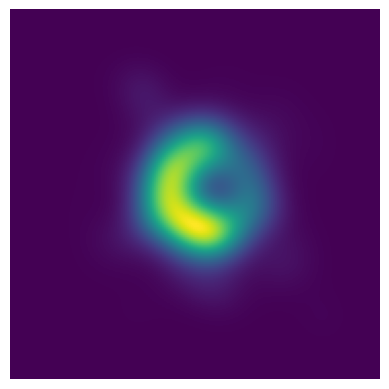

In [13]:
plt.figure()
plt.imshow(image)
plt.axis('off')

In [22]:
print(loss(image, data_list, coords, p = 2, reg_weight = 0))
#print(loss(image_shift_half, data_list, coords, p = 2, reg_weight = 0))

x [-1.85638326e+11 -1.83575678e+11 -1.81513029e+11 -1.79450381e+11
 -1.77387733e+11 -1.75325085e+11 -1.73262437e+11 -1.71199789e+11
 -1.69137141e+11 -1.67074493e+11 -1.65011845e+11 -1.62949197e+11
 -1.60886549e+11 -1.58823901e+11 -1.56761253e+11 -1.54698605e+11
 -1.52635957e+11 -1.50573309e+11 -1.48510660e+11 -1.46448012e+11
 -1.44385364e+11 -1.42322716e+11 -1.40260068e+11 -1.38197420e+11
 -1.36134772e+11 -1.34072124e+11 -1.32009476e+11 -1.29946828e+11
 -1.27884180e+11 -1.25821532e+11 -1.23758884e+11 -1.21696236e+11
 -1.19633588e+11 -1.17570940e+11 -1.15508291e+11 -1.13445643e+11
 -1.11382995e+11 -1.09320347e+11 -1.07257699e+11 -1.05195051e+11
 -1.03132403e+11 -1.01069755e+11 -9.90071070e+10 -9.69444589e+10
 -9.48818109e+10 -9.28191628e+10 -9.07565147e+10 -8.86938667e+10
 -8.66312186e+10 -8.45685706e+10 -8.25059225e+10 -8.04432744e+10
 -7.83806264e+10 -7.63179783e+10 -7.42553302e+10 -7.21926822e+10
 -7.01300341e+10 -6.80673861e+10 -6.60047380e+10 -6.39420899e+10
 -6.18794419e+10 -5.981

In [17]:
loss_arr = np.zeros((len(image),len(image[0])))
for i in range(len(image)):
    image_1 = np.roll(image, i, axis=1)
    for j in range(len(image[i])):
        image_2 = np.roll(image_1, j, axis = 0)
        loss_arr[i][j] = loss(image_2, data_list, coords, reg_weight=0)

In [18]:
np.min(loss_arr)

4.015861780619055e+26

In [19]:
np.max(loss_arr)

1.1508710253123274e+27

In [26]:
np.unravel_index(np.argmin(loss_arr, axis=None), loss_arr.shape)

(3, 174)

(-0.5, 179.5, 179.5, -0.5)

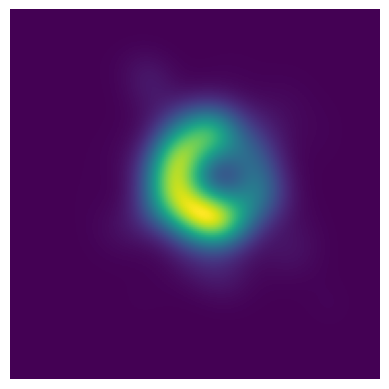

In [27]:
shift = np.roll(image, 3, axis=1)
shift = np.roll(shift, 174, axis = 0)
plt.figure()
plt.imshow(shift)
plt.axis('off')

(-0.5, 179.5, 179.5, -0.5)

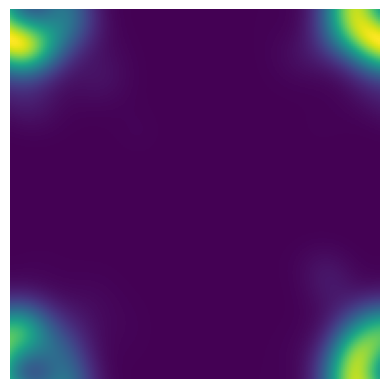

In [15]:
plt.figure()
plt.imshow(image_shift_half)
plt.axis('off')

Plot Loss function of image_copy - t * grad as a function of t in the gradient descent code
    Use t \in [-something to something]

Plot FF of image over onto the data

Document and Notebook

In [101]:
ft_image = np.fft.fftshift(np.fft.fft2(image))

(-0.5, 444.5, 889.5, -0.5)

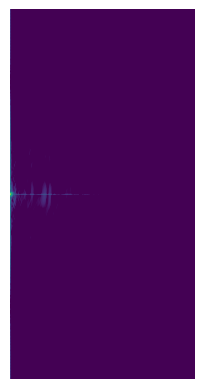

In [89]:
plt.figure()
plt.imshow(np.log(np.abs(ft_image)), vmin=10)
plt.axis('off')

X = U/Kx + 90
Y = U/Kx + 90

In [98]:
FOV=180*u.uas.to(u.rad)
kx_1 = (1)/FOV

In [99]:
x,y = [], []
for data in data_list:
    x.append((data.u/kx_1))
    y.append(data.v/kx_1+90)

(-29.77151350857831, 444.5, 889.5, -0.5)

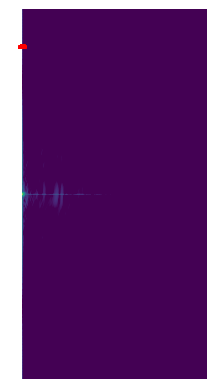

In [100]:
plt.figure()
plt.imshow(np.log(np.abs(ft_image)), vmin=10)
plt.scatter(x,y,color="red",s=0.1)
plt.axis('off')

(89.49669669404445, 90.50330145706666, 89.67631149013334, 90.09611837653333)

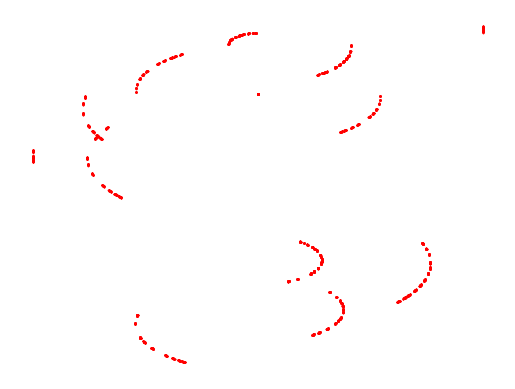

In [83]:
plt.figure()
plt.scatter(x,y,color="red",s=0.1)
plt.axis('off')

In [22]:
def gradient(data_list: list[data], coords, image, mode = 1): # 0 For central, -1 for backward, 1 for forward
    image_copy = np.copy(image, subok=True)
    upper_diff: float
    lower_diff: float
    h: float
    gradient_arr = np.empty(np.shape(image),dtype=np.complex_)
    if (mode == 0): # Central difference
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-6 / 2
                upper_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] -= 1e-6
                lower_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] = image[row,col] # Reset that pixel to original value
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-6
    elif (mode == -1): # Backward difference
        upper_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] -= 1e-8 # Check with Misha 
                lower_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    elif (mode == 1) : # Forward difference is default
        lower_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-8 # Check with Misha 
                upper_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    else:
        raise ValueError('Incorrect mode for finite differences')
    return gradient_arr
    #Return a Gradient 2d array?

In [23]:
image = np.zeros([80,80])
t = np.array(range(-100,101))/1000000000

grad = gradient(data_list, coords, image)
losses = []
for i in t:
    new_image = image - i * grad
    losses.append(loss(new_image, data_list, coords))

plt.figure()
plt.scatter(t,losses)
plt.axis('off')

KeyboardInterrupt: 

In [ ]:
t = np.array(range(-100,101))/1000000000
losses = []
for i in t:
    new_image = image - i * grad
    losses.append(loss(new_image, data_list, coords))

(-1.0999999999999999e-07,
 1.0999999999999999e-07,
 -13325724378738.113,
 279840590652824.8)

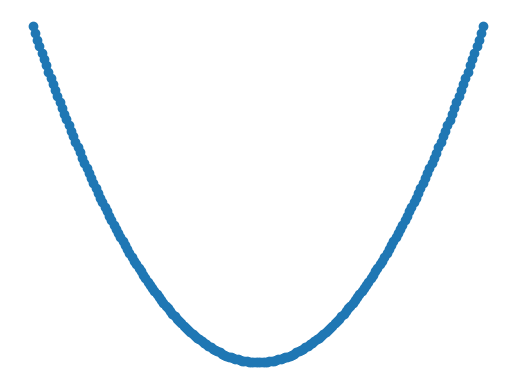

In [ ]:
plt.figure()
plt.scatter(t,losses)
plt.axis('off')

In [ ]:
losses.index(min(losses))-100

0